In [1]:
from glob import glob
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
import cftime

import pyart
from netCDF4 import Dataset


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [24]:
# radar_id = '66'
# date_str_list = ['20220201','20220202','20220203']

# radar_id = '71'
# date_str_list = ['20220201','20220202','20220203']

radar_id = '2'
date_str_list = ['20220127','20220128','20220129']

time_fmt = mdates.DateFormatter('%d/%m %HZ')

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
td_ts = []
alpha_ts = []
alpha_method_ts = []
system_phase_ts = []
system_phase_std_ts = []
mean_dp_rr = []
mean_sp_rr = []

for date_str in date_str_list:
    dp_path = f'/scratch/kl02/jss548/dprain/cfradial/{radar_id}/{date_str}'
    dp_ffn_list = sorted(glob(dp_path + '/*.nc'))
    for dp_ffn in tqdm(dp_ffn_list, total=len(dp_ffn_list)):
        with Dataset(dp_ffn) as radar:
            td_ts.append(cftime.num2pydate(radar['time'][0], radar['time'].units))
            if 'PHIDP_B' not in radar.variables.keys():
                alpha_ts.append(-np.nan)
                alpha_method_ts.append(np.nan)
                system_phase_ts.append(np.nan)
                system_phase_std_ts.append(np.nan)
                mean_dp_rr.append(np.nan)
                mean_sp_rr.append(np.nan)
            else:
                alpha_ts.append(radar['specific_attenuation'].alpha)
                alpha_method_ts.append(radar['specific_attenuation'].alpha_method)
                system_phase_ts.append(radar['PHIDP_B'].system_phase)
                system_phase_std_ts.append(radar['PHIDP_B'].system_phase_std)
                
                ah_rainrate = radar['ah_rainrate'][:]
                zr_rainrate = radar['zr_rainrate'][:]
                rr_mask = np.logical_and(ah_rainrate>=0, zr_rainrate>=0)
                mean_dp_rr.append(np.nanmean(ah_rainrate[rr_mask]))
                mean_sp_rr.append(np.nanmean(zr_rainrate[rr_mask]))
        

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 132/132 [01:02<00:00,  2.12it/s]


/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


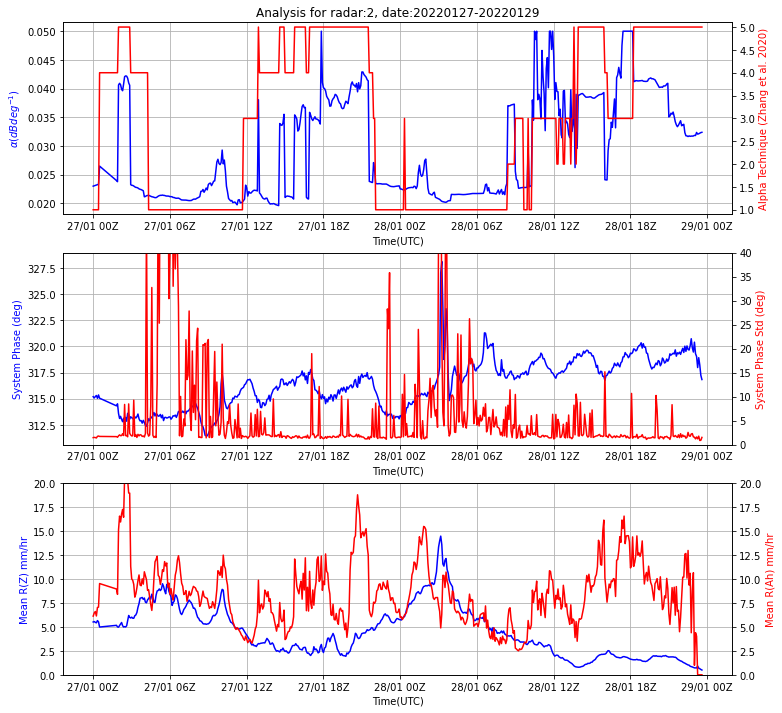

In [26]:
plt.figure(figsize=[12,12], facecolor='w')

ax1 = plt.subplot(311)
ax1.set_title(f'Analysis for radar:{radar_id}, date:{date_str_list[0]}-{date_str_list[-1]}')
ax1.plot(td_ts, alpha_ts, 'b-')
ax1.set_xlabel('Time(UTC)')
ax1.set_ylabel(r"$ \alpha (dB deg^{-1})$", color='b')
ax1.xaxis.set_major_formatter(time_fmt)
ax1.grid()
ax1a = ax1.twinx()
ax1a.plot(td_ts, alpha_method_ts, 'r-')
ax1a.set_ylim(0.9,5.1)
ax1a.set_ylabel("Alpha Technique (Zhang et al. 2020)", color='r')
ax1a.xaxis.set_major_formatter(time_fmt)

ax2 = plt.subplot(312)
ax2.plot(td_ts, system_phase_ts, 'b-')
ax2.set_xlabel('Time(UTC)')
ax2.set_ylabel("System Phase (deg)", color='b')
ax2.xaxis.set_major_formatter(time_fmt)
ax2.grid()
ax2a = ax2.twinx()
ax2a.plot(td_ts, system_phase_std_ts, 'r-')
ax2a.set_ylim(0,40)
ax2a.set_ylabel("System Phase Std (deg)", color='r')
ax2a.xaxis.set_major_formatter(time_fmt)


ax3 = plt.subplot(313)
ax3.plot(td_ts, mean_sp_rr, 'b-')
ax3.set_xlabel('Time(UTC)')
ax3.set_ylabel("Mean R(Z) mm/hr", color='b')
ax3.xaxis.set_major_formatter(time_fmt)
ax3.set_ylim(0,20)
ax3.grid()
ax3a = ax3.twinx()
ax3a.plot(td_ts, mean_dp_rr, 'r-')
ax3a.set_ylim(0,20)
ax3a.set_ylabel("Mean R(Ah) mm/hr", color='r')
ax3a.xaxis.set_major_formatter(time_fmt)

plt.savefig(f'{radar_id}_ts_analysis.png', dpi=100)